##### Import python modules

In [1]:
# Import Python Modules

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs

from cartopy.feature import ShapelyFeature
from datetime import datetime
from shapely.geometry import Polygon

import h3, jenkspy

##### Set global variables and display settings

In [2]:
# Display Settings

# Enable the view of all columns
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_colwidth", None)

# Enable the view of all rows
pd.set_option("display.max_rows", None)

In [3]:
# Define Global Variables

# ACLED dataset
ukraine_acled_geopandas = gpd.read_file(r"Data\ACLED\UKR_ACLED_MSc.shp")

# Ukraine country boundary
ukraine_boundary_geopandas = gpd.read_file(r"Data\Boundaries\UKR_Boundary.shp")

# Ukraine oblast bondaries
ukraine_oblast_geopandas = gpd.read_file(r"Data\Boundaries\UKR_Adm.shp")

# Global country boudnaries
global_boundary_geopandas = gpd.read_file(r"Data\Boundaries\GLB_Bnd.shp")

# Start, middle and end dates
date_start, date_mid, date_end = ((datetime(2021,12,1), datetime(2022,2,1), datetime(2022,3,18)))

# ACLED dataset columns to keep (date will be calculated later on)
columns_acled = ["actor1", "event_date", "date", "fatalities", "geometry"] 

##### Create and run functions for daily statistics

In [4]:
def convert_to_datetime(date):
    """
    Convert string date into a datetime object

    Parameters : 
    
        argument 1 (string) : Date to be converted, formatted as "02 March 2022"

    Returns : 

        datetime(argument 1) 
    """
    return datetime.strptime(date, "%d %B %Y")

In [5]:
def calculate_datetime_ranges(acled, columns, start, mid, end):
    
    """
    Create 3 new acled dataframes for the speicifed date ranges, keeping only those columns of interest

    Parameters : 
    
        argument 1 (geopandas dataframe) : Geopandas dataframe of the ACLED dataset

        argument 2 (list) : List of the columns to keep in with the dataframe

        argument 3 (datetime) : date of the start date

        argument 4 (datetime) : date of the middle date

        argument 5 (datetime) : date of the end date

    Returns : 

        geopandas dataframe : Date range start - end

        geopandas dataframe : Date range start - mid
        
        geopandas dataframe : Date range mid - end
    """

    # Create a new column called "date" and convert the original string dates into datetime
    acled["date"] = acled["event_date"].apply(convert_to_datetime)

    # Create geopandas dataframes for date range start - end
    acled_daterange_se = acled[(acled["date"] >= start) & (acled["date"] <= end)]

    # Create geopandas dataframes for date range start - mid
    acled_daterange_sm = acled[(acled["date"] < mid) & (acled["date"] >= start)]
    
    # Create geopandas dataframes for date range mid - end
    acled_daterange_me = acled[(acled["date"] >= mid) & (acled["date"] <= end)]
    
    return acled_daterange_se[columns].sort_values(by=["date"]), acled_daterange_sm[columns].sort_values(by=["date"]), acled_daterange_me[columns].sort_values(by=["date"])


In [6]:
# Tuple unpack returned dataframes
acled_daterange_se, acled_daterange_sm, acled_daterange_me = calculate_datetime_ranges(ukraine_acled_geopandas, columns_acled, date_start, date_mid, date_end)

# Check dataframe format
acled_daterange_me.head()

,actor1,event_date,date,fatalities,geometry
2756,Protesters (Ukraine),01 February 2022,2022-02-01,0,POINT (30.52240 50.44960)
2730,Military Forces of Ukraine (2019-),01 February 2022,2022-02-01,0,POINT (37.54920 47.95120)
2731,Military Forces of Ukraine (2019-),01 February 2022,2022-02-01,0,POINT (37.81100 47.17450)
2732,Military Forces of Ukraine (2019-),01 February 2022,2022-02-01,0,POINT (37.90760 47.29720)
2733,Military Forces of Ukraine (2019-),01 February 2022,2022-02-01,0,POINT (37.71210 48.06120)


In [7]:
def calculate_statistics(acled_all):
    """
    Calculate statistics required for counts, fatalities, actors and locations for future products

    Parameters : 
    
        argument 1 (geopandas dataframe) : Geopandas dataframe of the ACLED dataset (date range start - end)

    Returns : 

        geopandas dataframe : count, fatalities and actors statistics for start - end
    """

    # Store unique dates in a list
    unique_dates_set = set(acled_all["date"].tolist())
    unique_dates = list(unique_dates_set)
    unique_dates.sort()

    # Create dictionary to store statistics
    statistics_by_date = {
        "date" : [],
        "count" : [],
        "fatalities" : [],
        "count_sum" : [],
        "fatalities_sum" : [], 
        "russian_actor" : [],
        "ukraine_actor" : [],
        "other_actor" : []
    }
    
    # Create counter variables
    count_sum = 0
    count_fatal = 0

    # Iterate over unique dates to create daily statistics
    for date in unique_dates:

        # Calculate daily statistics
        daily_count = acled_all["date"].value_counts()[date]
        daily_fatal = acled_all.loc[acled_all["date"] == date, "fatalities"].sum()
        daily_events = acled_all[acled_all["date"] == date]
        daily_russian = len(daily_events[daily_events["actor1"].str.contains("Russia")])
        daily_ukraine = len(daily_events[daily_events["actor1"].str.contains("Ukraine")])
        daily_other = daily_count - daily_russian - daily_ukraine

        # Append daily statistics
        statistics_by_date["date"].append(date)
        statistics_by_date["count"].append(daily_count)
        statistics_by_date["fatalities"].append(daily_fatal)
        statistics_by_date["count_sum"].append(count_sum + daily_count)
        statistics_by_date["fatalities_sum"].append(count_fatal + daily_fatal)
        statistics_by_date["russian_actor"].append(daily_russian)
        statistics_by_date["ukraine_actor"].append(daily_ukraine)
        statistics_by_date["other_actor"].append(daily_other)

        # Update counters
        count_sum += daily_count
        count_fatal += daily_fatal

    return pd.DataFrame(statistics_by_date).sort_values(by=["date"])


In [8]:
# Assigned variables to returned dataframe
acled_daily_statistics = calculate_statistics(acled_daterange_se)

# Check dataframe format
acled_daily_statistics.head()

,date,count,fatalities,count_sum,fatalities_sum,russian_actor,ukraine_actor,other_actor
0,2021-12-01,25,1,25,1,0,14,11
1,2021-12-02,35,0,60,1,0,24,11
2,2021-12-03,31,0,91,1,0,20,11
3,2021-12-04,10,0,101,1,0,4,6
4,2021-12-05,10,0,111,1,0,4,6


##### Create graphs for daily statistics

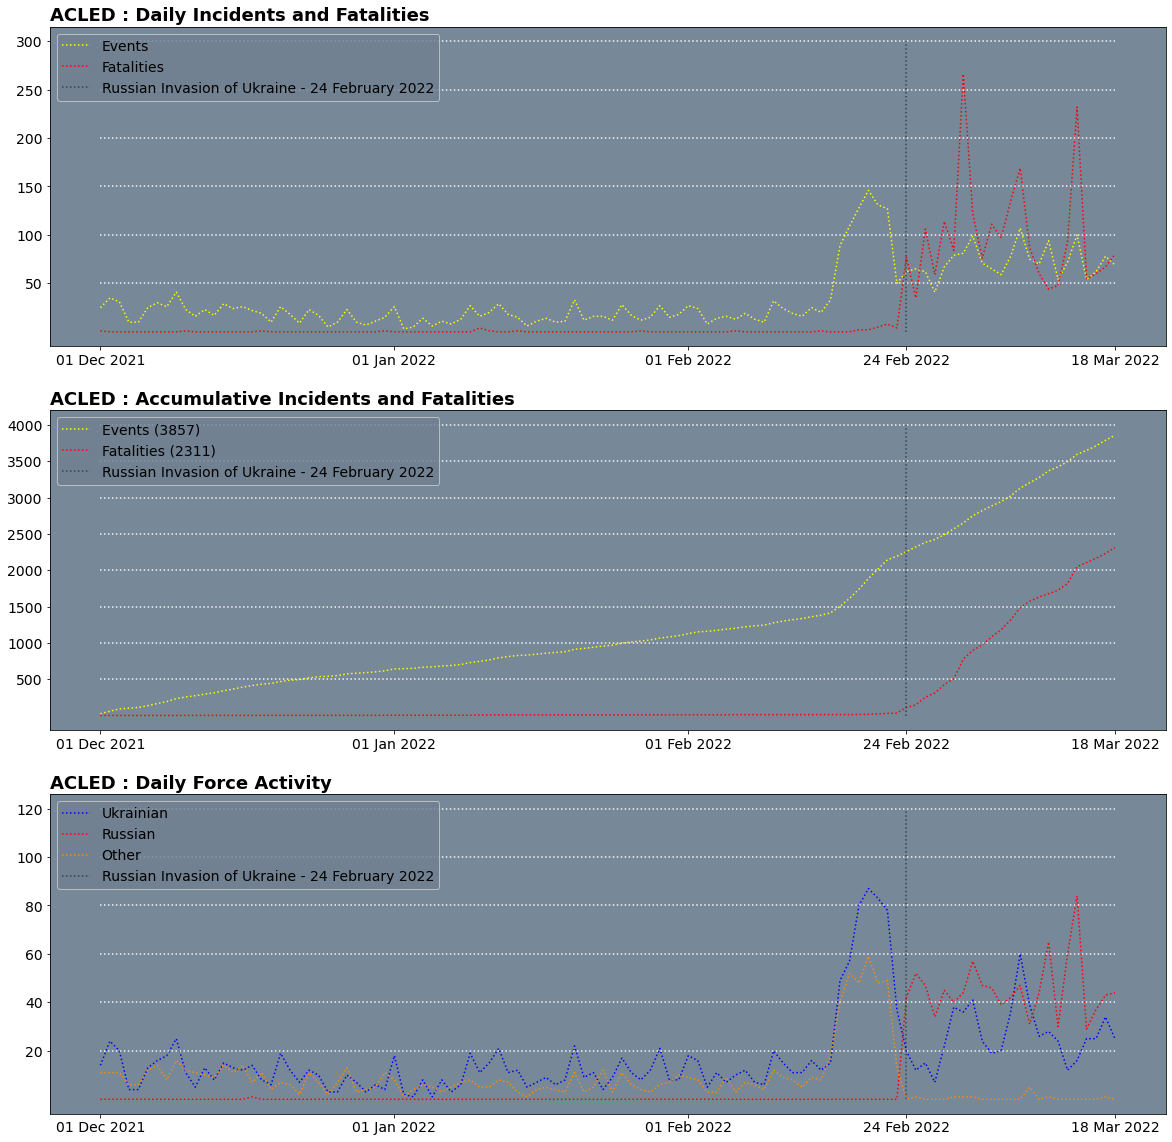

In [9]:
# Create figure and axis
figure_1, (axis_1, axis_2, axis_3) = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

axis_list = [axis_1, axis_2, axis_3]

# Set titles
axis_1.set_title("ACLED : Daily Incidents and Fatalities", 
                 fontsize=18, 
                 loc="left", 
                 weight="bold")

axis_2.set_title("ACLED : Accumulative Incidents and Fatalities", 
                 fontsize=18, 
                 loc="left", 
                 weight="bold")

axis_3.set_title("ACLED : Daily Force Activity", 
                 fontsize=18, 
                 loc="left", 
                 weight="bold")

# Plot daily statistics by date
axis_1.plot(acled_daily_statistics["date"], 
            acled_daily_statistics["count"], 
            color="yellow", 
            linestyle=":",
            label="Events")

axis_1.plot(acled_daily_statistics["date"], 
            acled_daily_statistics["fatalities"], 
            color="r", 
            linestyle=":", 
            label="Fatalities")

axis_2.plot(acled_daily_statistics["date"], 
            acled_daily_statistics["count_sum"], 
            color="yellow", 
            linestyle=":",
            label="Events (3857)")

axis_2.plot(acled_daily_statistics["date"], 
            acled_daily_statistics["fatalities_sum"],
            color="r", 
            linestyle=":",
            label="Fatalities (2311)")

axis_3.plot(acled_daily_statistics["date"], 
            acled_daily_statistics["ukraine_actor"], 
            color="blue", 
            linestyle=":",
            label="Ukrainian")

axis_3.plot(acled_daily_statistics["date"], 
            acled_daily_statistics["russian_actor"], 
            color="red", 
            linestyle=":",
            label="Russian")

axis_3.plot(acled_daily_statistics["date"], 
            acled_daily_statistics["other_actor"], 
            color="darkorange", 
            linestyle=":",
            label="Other")

# Set x and y axis labels
x_ticks = [date_start, datetime(2022,1,1), datetime(2022,2,1), datetime(2022,2,24), date_end]

y_ticks = [[i for i in range(50, acled_daily_statistics["fatalities"].max() + 50, 50)], 
           [i for i in range(500, acled_daily_statistics["count_sum"].max() + 500, 500)],
           [i for i in range(20, acled_daily_statistics["count"].max() - 20, 20)]]

# Format styling and legend
for i, ax in enumerate(axis_list):
    ax.set_facecolor("lightslategray")
    ax.set_xticks(
        ticks=x_ticks, 
        labels=["01 Dec 2021", "01 Jan 2022", "01 Feb 2022", "24 Feb 2022", "18 Mar 2022"],
        fontsize=14
    )
    ax.set_yticks(ticks=y_ticks[i], labels=y_ticks[i], fontsize=14)
    ax.hlines(y=y_ticks[i], xmin=date_start, xmax=date_end, color="whitesmoke", linestyle=":")
    ax.vlines(
        x=mdates.date2num(datetime(2022,2,24)), 
        ymin=0, 
        ymax=y_ticks[i][-1],
        color="k", 
        linestyle=":",
        alpha=0.5,
        label="Russian Invasion of Ukraine - 24 February 2022"
    )
    ax.legend(fontsize=14, loc="upper left", facecolor="slategray")

In [218]:
def count_by_oblast(oblasts, acled):
    
    """
    Count the occurances and fatalities for each region

    Parameters : 

        argument 1 (geopandas dataframe) : Geopandas dataframe of the country boundaries dataset
    
        argument 2 (geopandas dataframe) : Geopandas dataframe of the ACLED dataset

    Returns : 

        statistics for each oblast (geopandas dataframe) : region, count, fatalities and geometry
    """

    # Create dictionary to store statistics
    statistics_by_oblast = {
        "Region" : [],
        "count" : [],
        "fatalities" : []
    }

    # Perform Spatial Join
    acled_oblast_sj = gpd.sjoin(oblasts, acled, how='inner', lsuffix='left', rsuffix='right')

    # Get a list of all region names
    unique_regions = set(acled_oblast_sj['Region'].tolist())
    unique_regions = list(unique_regions)
    unique_regions.sort()

    # Update dictionary for regions, counts and fatalities
    for region in unique_regions:
        fatal = acled_oblast_sj.loc[acled_oblast_sj["Region"] == region, "fatalities"].sum()
        count = acled_oblast_sj["Region"].value_counts()[region]

        statistics_by_oblast["Region"].append(region)#.split(" region")[0])
        statistics_by_oblast["count"].append(count)
        statistics_by_oblast["fatalities"].append(fatal)

    # Convert dictionary into pandas dataframe
    statistics_by_oblast_pandas = pd.DataFrame(statistics_by_oblast)

    # Merge regions statistics to oblast regions to link geometry
    oblast_statistics = statistics_by_oblast_pandas.merge(oblasts[["Region", "geometry"]])
    
    return oblast_statistics

In [219]:
# Spatially join ACLED to country oblasts
oblast_statistics = count_by_oblast(ukraine_oblast_geopandas, acled_daterange_se)